In [0]:
#@title Imports
!pip install --upgrade jax==0.1.57 jaxlib==0.1.37

from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd
from functools import partial
import jax
import jax.numpy as jp
import jax.scipy as jsp
from jax.experimental import stax # neural network library
from jax.experimental.stax import GeneralConv, Conv, ConvTranspose, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout, Tanh, Sigmoid, BatchNorm # neural network layers
from jax.nn import softmax, sigmoid
from jax.nn.initializers import zeros
import matplotlib.pyplot as plt # visualization
import numpy as np
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays
from jax.ops import index, index_add, index_update
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os, time
import gym
import torch
from jax.ops import index, index_add, index_update

rng=jax.random.PRNGKey(1234)

     |████████████████████████████████| 256kB 4.9MB/s 
     |████████████████████████████████| 25.4MB 1.4MB/s 
  Created wheel for jax: filename=jax-0.1.57-cp36-none-any.whl size=297709 sha256=b9647c12c0eacba170b5cd3b673bc5176eb98de8cb36ba56b9a466ccd92d6e28
  Stored in directory: /root/.cache/pip/wheels/8a/b4/75/859bcdaf181569124306615bd9b68c747725c60bfa68826378
  Created wheel for fastcache: filename=fastcache-1.1.0-cp36-cp36m-linux_x86_64.whl size=39200 sha256=ba351efa62f42f646c4866ff045f61fd1983424fec56f0165d584f6a927490f6
  Stored in directory: /root/.cache/pip/wheels/6a/80/bf/30024738b03fa5aa521e2a2ac952a8d77d0c65e68d92bcd3b6
Successfully built jax fastcache
  Found existing installation: jax 0.1.58
    Uninstalling jax-0.1.58:
      Successfully uninstalled jax-0.1.58
  Found existing installation: jaxlib 0.1.38
    Uninstalling jaxlib-0.1.38:
      Successfully uninstalled jaxlib-0.1.38


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [0]:
#@markdown Game definitions for matching pennies, iterated prisoner's
#@markdown dilemma and tandem (define your own here).

def matching_pennies():
  dims = [1, 1]
  payout_mat_1 = jp.array([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    # th=jp.stack(th).reshape(-1)
    p_1, p_2 = sigmoid(th[0]), sigmoid(th[1])
    x, y = jp.array([p_1, 1-p_1]), jp.array([p_2, 1-p_2])
    # print(x.shape,y.shape,payout_mat_1.shape,payout_mat_2.shape)
    L_1 = jp.dot(jp.dot(x.T, payout_mat_1), y)
    L_2 = jp.dot(jp.dot(x.T, payout_mat_2), y)
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

def torch_matching_pennies():
  dims = [1, 1]
  payout_mat_1 = torch.Tensor([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
    x, y = torch.cat([p_1, 1-p_1]), torch.cat([p_2, 1-p_2])
    L_1 = torch.matmul(torch.matmul(x, payout_mat_1), y)
    L_2 = torch.matmul(torch.matmul(x, payout_mat_2), y)
    return [L_1, L_2]
  return dims, Ls

def tandem():
  dims = [1, 1]
  def Ls(th):
    x, y = th
    L_1 = (x+y)**2-2*x
    L_2 = (x+y)**2-2*y
    return [L_1.reshape(-1)[0], L_2.reshape(-1)[0]]
  return dims, Ls

def torch_tandem():
  return tandem()

def ipd(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = jp.array([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  def Ls(th):
    p_1_0 = sigmoid(th[0][0:1])
    p_2_0 = sigmoid(th[1][0:1])
    p = jp.stack([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)], axis=1)
    # print('p',p,p.shape)
    p_1 = jp.reshape(sigmoid(th[0][1:5]), (4, 1))
    p_2 = jp.reshape(sigmoid(th[1][1:5]), (4, 1))
    P = jp.stack([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], axis=1).reshape((4,4))
    # print('P',P,P.shape)
    # print('inv', jsp.linalg.inv(jp.eye(4)-gamma*P), jsp.linalg.inv(jp.eye(4)-gamma*P).shape)
    M = -jp.dot(p, jsp.linalg.inv(jp.eye(4)-gamma*P))
    # print('M',M)
    L_1 = jp.dot(M, jp.reshape(payout_mat_1, (4, 1)))
    L_2 = jp.dot(M, jp.reshape(payout_mat_2, (4, 1)))
    # print('L_1',L_1.reshape(-1)[0])
    # print('L_2',L_2.reshape(-1)[0])
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

def torch_ipd(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = torch.Tensor([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  def Ls(th):
    p_1_0 = torch.sigmoid(th[0][0:1])
    p_2_0 = torch.sigmoid(th[1][0:1])
    p = torch.cat([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)])
    p_1 = torch.reshape(torch.sigmoid(th[0][1:5]), (4, 1))
    p_2 = torch.reshape(torch.sigmoid(th[1][1:5]), (4, 1))
    P = torch.cat([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], dim=1)
    M = -torch.matmul(p, torch.inverse(torch.eye(4)-gamma*P))
    L_1 = torch.matmul(M, torch.reshape(payout_mat_1, (4, 1)))
    L_2 = torch.matmul(M, torch.reshape(payout_mat_2, (4, 1)))
    return [L_1, L_2]
  return dims, Ls




In [0]:
#@markdown Gradient computations for each algorithm.

def init_th(dims, std):
  th = []
  init=random.normal(rng, shape=(jp.sum(jp.array(dims)),))
  if std > 0:
    init*=std
  for i in range(len(dims)):
    th.append(init[:dims[i]])
    init=init[dims[i]:]
  return jp.array(th)

def get_hessian(th, Ls):
    n, d = th.shape[0],th.shape[1]
    hess_L = [jacobian(lambda y,i:jacobian(Ls)(y)[i][i])(th,i).reshape((n, d, d)) for i in range(n)]
    return jp.stack(hess_L)

# @jax.jit
def get_gradient(Ls, th):
    grad_L = jacobian(Ls)(th)
    return grad_L

def update_th(Ls, dims, alpha, algo, th, a=0.5, b=0.1, gam=1, ep=0.1, lss_lam=0.1):
    n = th.shape[0]
    losses = Ls(th)
    # sum_dim=sum(dims)

    grad_L = jacobian(Ls)(th) # n x n x d
    if algo=='la':
        ''' Implementation 1 : Using Hessian
        xi = jp.einsum('iij->ij',grad_L)
        full_hessian = jax.hessian(Ls)(th)
        off_diag_hessian = full_hessian
        for i in range(th.shape[0]):
            off_diag_hessian = index_update(off_diag_hessian, index[i,i,:,:,:], 0)
        second_term = jp.einsum('iim->im',jp.einsum('ijklm,jk->ilm', off_diag_hessian, xi))
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        grads=xi - alpha*second_term
        '''
        ''' Implementation 2 : Similar to torch way 
        def fn(th):
            xi = jp.einsum('ii...->i...', jax.jacrev(Ls)(th))
            off_diag_g = jax.jacrev(Ls)(th)
            for i in range(th.shape[0]):
                off_diag_g = index_update(off_diag_g, index[i,i], 0)
            prod = jp.einsum('ijk,jk->i', off_diag_g, jp.lax.stop_gradient(xi))
            return prod
        xi = jp.einsum('iij->ij',grad_L)
        grads = xi - alpha*jp.einsum('ii...->i...', jax.jacrev(fn)(th))'''
        ''' Implementation 3 : Using JVP '''
        def fn1(th):
            xi = jp.lax.stop_gradient(jp.einsum('ii...->i...', jax.jacrev(Ls)(th)))
            _, prod = jax.jvp(Ls, (th,), (xi,))
            return (prod - jp.einsum('ij,ij->i', xi, xi))
        xi = jp.einsum('iij->ij',grad_L)
        grads = xi - alpha * jp.einsum('ii...->i...', jax.jacrev(fn1)(th))

    elif algo == 'lola':
        ''' Implementation 1 : Using Hessian
        xi = jp.einsum('iij->ij',grad_L)
        full_hessian = jax.hessian(Ls)(th)
        off_diag_hessian = full_hessian
        for i in range(th.shape[0]):
            off_diag_hessian = index_update(off_diag_hessian, index[i,i,:,:,:], 0)
        second_term = jp.einsum('iim->im',jp.einsum('ijklm,jk->ilm', off_diag_hessian, xi))
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,grad_L))
        grads=xi - alpha*second_term - alpha*third_term
        '''
        ''' Implementation 2 : Similar to torch way 
        def fn(th):
            xi = jp.einsum('ii...->i...', jax.jacrev(Ls)(th))
            off_diag_g = jax.jacrev(Ls)(th)
            for i in range(th.shape[0]):
                off_diag_g = index_update(off_diag_g, index[i,i], 0)
            prod = jp.einsum('ijk,jk->i', off_diag_g, xi)
            return prod
        xi = jp.einsum('iij->ij',grad_L)
        grads = xi - alpha*jp.einsum('ii...->i...', jax.jacrev(fn)(th))'''
        ''' Implementation 3 : Using JVP '''
        def fn1(th):
            xi = jp.einsum('ii...->i...', jax.jacrev(Ls)(th))
            _, prod = jax.jvp(Ls, (th,), (xi,))
            return (prod - jp.einsum('ij,ij->i', xi, xi))
        xi = jp.einsum('iij->ij',grad_L)
        grads = xi - alpha * jp.einsum('ii...->i...', jax.jacrev(fn1)(th))

    elif algo == 'symlola':
        def fn1(th):
            xi = jp.einsum('ii...->i...', jax.jacrev(Ls)(th))
            _, prod = jax.jvp(Ls, (th,), (xi,))
            return prod
        xi = jp.einsum('iij->ij',grad_L)
        grads = xi - alpha * jp.einsum('ii...->i...', jax.jacrev(fn1)(th))

    else: # Naive Learning
        grads = jp.einsum('iij->ij',grad_L)

    th = th - alpha*grads.reshape(th.shape)
    return th, losses

def symlola(Ls, dims, alpha, lr, th, a=0.5, b=0.1, gam=1, ep=0.1, lss_lam=0.1):
    n = th.shape[0]
    losses = Ls(th)
    # sum_dim=sum(dims)

    grad_L = jacobian(Ls)(th) # n x n x d
    def fn1(th):
        xi = jp.einsum('ii...->i...', jax.jacrev(Ls)(th))
        _, prod = jax.jvp(Ls, (th,), (xi,))
        return (prod - jp.einsum('ij,ij->i', xi, xi))
    xi = jp.einsum('iij->ij',grad_L)
    grads = xi - alpha * jp.einsum('ii...->i...', jax.jacrev(fn1)(th))
    th = th - alpha*grads.reshape(th.shape)
    return th, losses


In [0]:
#@title Testing code
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = ipd()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)

# Set num_epochs, learning rate and learning algo
num_epochs = 100
alpha = 1
algo = 'lola'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=partial(update_th,Ls,dims,alpha,algo)

# Run
th, losses = update_fn(th)


Correct: [[-0.0131653 ]
 [-0.13574281]]
(2,)
New: [[-0.01316529]
 [-0.13574281]]


In [0]:
#@title torch code
def torch_init_th(dims, std):
  th = []
  for i in range(len(dims)):
    if std > 0:
      init = torch.nn.init.normal_(torch.empty(dims[i], requires_grad=True), std=std)
    else:
      init = torch.zeros(dims[i], requires_grad=True)
    th.append(init)
  return th

def torch_get_gradient(function, param):
  grad = torch.autograd.grad(function, param, create_graph=True)[0]
  return grad

def torch_get_hessian(th, grad_L, diag=True, off_diag=True):
  n = len(th)
  H = []
  for i in range(n):
    row_block = []
    for j in range(n):
      if (i == j and diag) or (i != j and off_diag):
        block = [torch.unsqueeze(torch_get_gradient(grad_L[i][i][k], th[j]), dim=0) 
                  for k in range(len(th[i]))]
        row_block.append(torch.cat(block, dim=0))
      else:
        row_block.append(torch.zeros(len(th[i]), len(th[j])))
    H.append(torch.cat(row_block, dim=1))
  return torch.cat(H, dim=0)

def torch_update_th(th, Ls, alpha, algo, a=0.5, b=0.1, gam=1, ep=0.1, lss_lam=0.1):
  n = len(th)
  losses = Ls(th)

  # Compute gradients
  grad_L = [[torch_get_gradient(losses[j], th[i]) for j in range(n)] for i in range(n)]
  if algo == 'la':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*torch_get_gradient(terms[i], th[i]) for i in range(n)]
  elif algo == 'lola':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j])
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*torch_get_gradient(terms[i], th[i]) for i in range(n)]
  elif algo == 'sos':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    xi_0 = [grad_L[i][i]-alpha*torch_get_gradient(terms[i], th[i]) for i in range(n)]
    chi = [torch_get_gradient(sum([torch.dot(grad_L[j][i].detach(), grad_L[j][j])
              for j in range(n) if j != i]), th[i]) for i in range(n)]
    # Compute p
    dot = torch.dot(-alpha*torch.cat(chi), torch.cat(xi_0))
    p1 = 1 if dot >= 0 else min(1, -a*torch.norm(torch.cat(xi_0))**2/dot)
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    xi_norm = torch.norm(xi)
    p2 = xi_norm**2 if xi_norm < b else 1
    p = min(p1, p2)
    grads = [xi_0[i]-p*alpha*chi[i] for i in range(n)]
  elif algo == 'sga':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    H_t_xi = [torch_get_gradient(ham, th[i]) for i in range(n)]
    H_xi = [torch_get_gradient(sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
              for j in range(n)]), th[i]) for i in range(n)]
    A_t_xi = [H_t_xi[i]/2-H_xi[i]/2 for i in range(n)]
    # Compute lambda (sga with alignment)
    dot_xi = torch.dot(xi, torch.cat(H_t_xi))
    dot_A = torch.dot(torch.cat(A_t_xi), torch.cat(H_t_xi))
    d = sum([len(th[i]) for i in range(n)])
    lam = torch.sign(dot_xi*dot_A/d+ep)
    grads = [grad_L[i][i]+lam*A_t_xi[i] for i in range(n)]
  elif algo == 'co':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    grads = [grad_L[i][i]+gam*torch_get_gradient(ham, th[i]) for i in range(n)]
  elif algo == 'eg':
    th_eg = [th[i]-alpha*torch_get_gradient(losses[i], th[i]) for i in range(n)]
    losses_eg = Ls(th_eg)
    grads = [torch_get_gradient(losses_eg[i], th_eg[i]) for i in range(n)]
  elif algo == 'cgd': # Slow implementation (matrix inversion)
    dims = [len(th[i]) for i in range(n)]
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    H_o = torch_get_hessian(th, grad_L, diag=False)
    grad = torch.matmul(torch.inverse(torch.eye(sum(dims))+alpha*H_o), xi)
    grads = [grad[sum(dims[:i]):sum(dims[:i+1])] for i in range(n)]
  elif algo == 'lss': # Slow implementation (matrix inversion)
    dims = [len(th[i]) for i in range(n)]
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    H = torch_get_hessian(th, grad_L)
    if torch.det(H) == 0:
      inv = torch.inverse(torch.matmul(H.T, H)+lss_lam*torch.eye(sum(dims)))
      H_inv = torch.matmul(inv, H.T)
    else:
      H_inv = torch.inverse(H)
    grad = torch.matmul(torch.eye(sum(dims))+torch.matmul(H.T, H_inv), xi)/2
    grads = [grad[sum(dims[:i]):sum(dims[:i+1])] for i in range(n)]
  else: # Naive Learning
    grads = [grad_L[i][i] for i in range(n)]

  # Update theta
  with torch.no_grad():
    for i in range(n):
      th[i] -= alpha*grads[i]
  return th, losses


Jax time: 0.14378023147583008


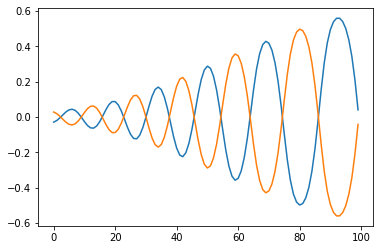

Torch time: 0.12993717193603516


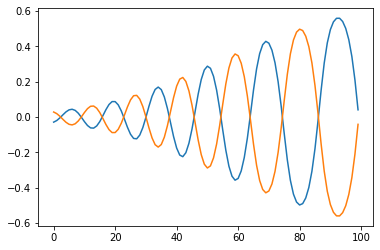

In [0]:
#@title Matching pennies NL
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()
torch_dims, torch_Ls = torch_matching_pennies()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
torch_th = [torch.from_numpy(np.array(x)) for x in th]
for x in torch_th:
    x.requires_grad=True

# Set num_epochs, learning rate and learning algo
num_epochs = 100
alpha = 1
algo = 'nl'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=jit(partial(update_th,Ls,dims,alpha,algo))

# Run
t1 = time.time()
losses_out = np.zeros((num_epochs, len(th)))
th_out = []
for k in range(num_epochs):
  th, losses = update_fn(th)
#   print(k,'th',th)
#   th_out.append([np.array(th[i]) for i in range(th.shape[0])])
  losses_out[k] = losses#[loss for loss in losses]
print('Jax time:', time.time()-t1)
plt.plot(losses_out)
plt.show()

t1 = time.time()
losses_out = np.zeros((num_epochs, len(torch_th)))
th_out = []
for k in range(num_epochs):
  torch_th, losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
  th_out.append([torch_th[i].data.numpy() for i in range(len(torch_th))])
  losses_out[k] = [loss.data.numpy() for loss in losses]
print('Torch time:', time.time()-t1)
plt.plot(losses_out)
plt.show()


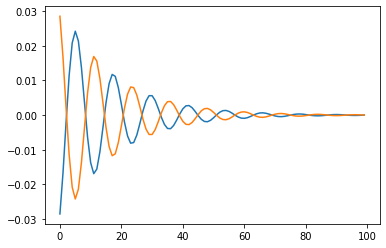

Jax time: 1.060194969177246


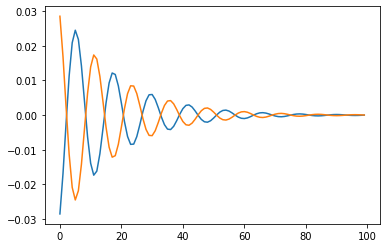

Torch time: 0.2887132167816162


In [0]:
#@title Matching pennies LA
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()
torch_dims, torch_Ls = torch_matching_pennies()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
torch_th = [torch.from_numpy(np.array(x)) for x in th]
for x in torch_th:
    x.requires_grad=True

# Set num_epochs, learning rate and learning algo
num_epochs = 100
alpha = 1
algo = 'la'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=jit(partial(update_th,Ls,dims,alpha,algo))

# Run
t1 = time.time()
losses_out = np.zeros((num_epochs, len(th)))
th_out = []
for k in range(num_epochs):
  th, losses = update_fn(th)
  th_out.append([np.array(th[i][0]) for i in range(len(th))])
  losses_out[k] = [loss for loss in losses]
plt.plot(losses_out)
plt.show()
print('Jax time:', time.time()-t1)

t1 = time.time()
losses_out = np.zeros((num_epochs, len(torch_th)))
th_out = []
for k in range(num_epochs):
  torch_th, losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
  th_out.append([torch_th[i].data.numpy() for i in range(len(torch_th))])
  losses_out[k] = [loss.data.numpy() for loss in losses]
plt.plot(losses_out)
plt.show()
print('Torch time:', time.time()-t1)


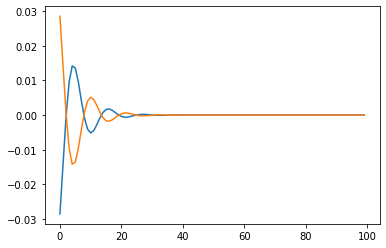

Jax time: 0.7537720203399658


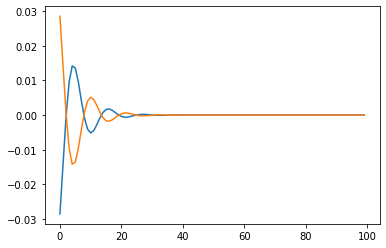

Torch time: 0.2859506607055664


In [0]:
#@title Matching pennies LOLA
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()
torch_dims, torch_Ls = torch_matching_pennies()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
torch_th = [torch.from_numpy(np.array(x)) for x in th]
for x in torch_th:
    x.requires_grad=True

# Set num_epochs, learning rate and learning algo
num_epochs = 100
alpha = 1
algo = 'lola'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=jit(partial(update_th,Ls,dims,alpha,algo))

# Run
t1 = time.time()
losses_out = np.zeros((num_epochs, len(th)))
th_out = []
for k in range(num_epochs):
  th, losses = update_fn(th)
#   th_out.append([np.array(th[i][0]) for i in range(len(th))])
  losses_out[k] = [loss for loss in losses]
plt.plot(losses_out)
plt.show()
print('Jax time:', time.time()-t1)

t1 = time.time()
losses_out = np.zeros((num_epochs, len(torch_th)))
th_out = []
for k in range(num_epochs):
  torch_th, losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
  th_out.append([torch_th[i].data.numpy() for i in range(len(torch_th))])
  losses_out[k] = [loss.data.numpy() for loss in losses]
plt.plot(losses_out)
plt.show()
print('Torch time:', time.time()-t1)


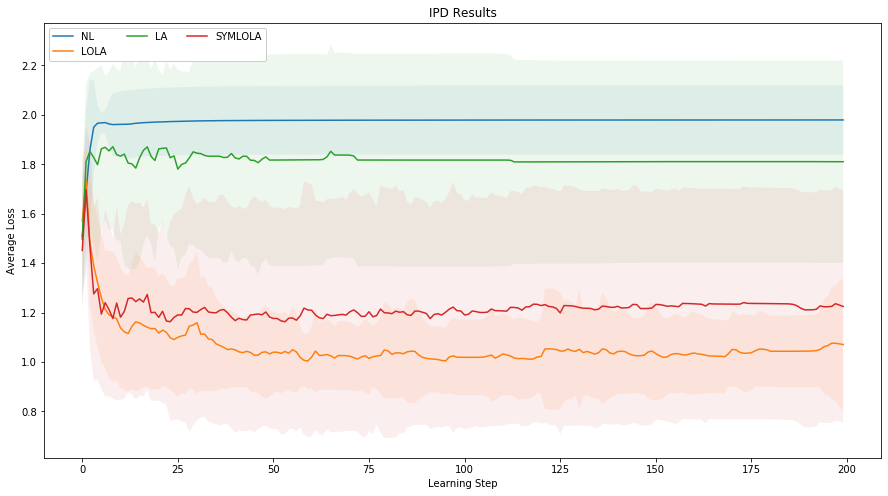

Jax time: 120.78639841079712


In [0]:
#@title IPD jax
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
alpha = 1
std = 1

th = init_th(dims, std)
update_fn={'nl':jit(partial(update_th,Ls,dims,alpha,'nl')),
           'la':jit(partial(update_th,Ls,dims,alpha,'la')),
           'lola':jit(partial(update_th,Ls,dims,alpha,'lola')),
           'symlola':jit(partial(update_th,Ls,dims,alpha,'symlola'))}

def convert2torch(th):
    torch_th = [torch.from_numpy(np.array(x)) for x in th]
    for x in torch_th:
        x.requires_grad=True
    return torch_th

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
plt.figure(figsize=(15, 8))
for algo in ['nl', 'lola', 'la', 'symlola', 'sos', 'sga', 'co' , 'eg', 'cgd', 'lss'][0:4]:
  losses_out = np.zeros((num_runs, num_epochs))
#   torch_losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    # th = init_th(dims, std)
    # torch_th = convert2torch(th)
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    for k in range(num_epochs):
    #   torch_th, torch_losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
    #   torch_losses_out[i, k] = (1-gamma)*torch_losses[0].data.numpy()
      th, losses = update_fn[algo](th)
      losses_out[i, k] = (1-gamma)*losses[0]
#   torch_mean = np.mean(torch_losses_out, axis=0)
#   torch_dev = np.std(torch_losses_out, axis=0)
  mean = np.mean(losses_out, axis=0)
  dev = np.std(losses_out, axis=0)
#   plt.plot(np.arange(num_epochs), torch_mean)
#   plt.fill_between(np.arange(num_epochs), torch_mean-torch_dev, torch_mean+torch_dev, alpha=0.08)
  plt.plot(np.arange(num_epochs), mean)
  plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)

plt.title('IPD Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['NL', 'LOLA', 'LA', 'SYMLOLA', 'SOS', 'SGA', 'CO',  'EG', 'CGD', 'LSS' ][0:4], loc='upper left', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

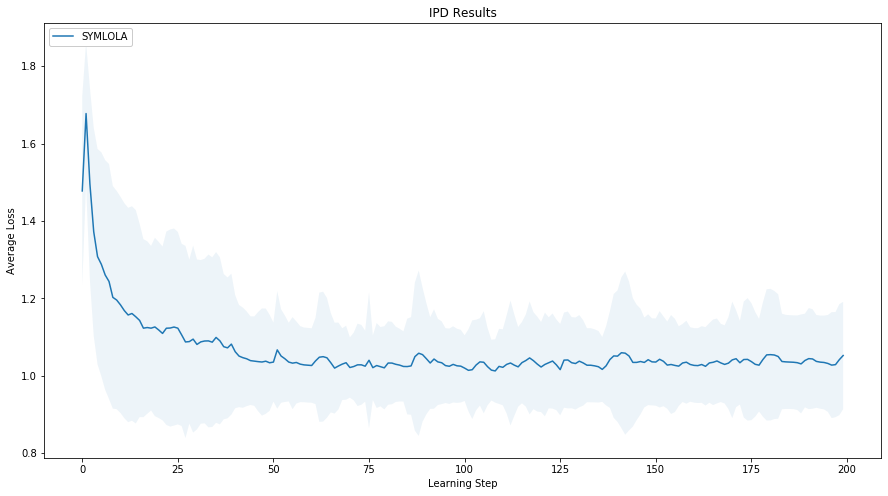

Jax time: 40.79619216918945


In [0]:
#@title IPD jax - tune Sym LOLA
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
alpha = 1
lr=1
std = 1

th = init_th(dims, std)
update_fn=jit(partial(symlola,Ls,dims,alpha,lr))

def convert2torch(th):
    torch_th = [torch.from_numpy(np.array(x)) for x in th]
    for x in torch_th:
        x.requires_grad=True
    return torch_th

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
plt.figure(figsize=(15, 8))
for algo in ['nl', 'lola', 'la', 'symlola', 'sos', 'sga', 'co' , 'eg', 'cgd', 'lss'][3:4]:
  losses_out = np.zeros((num_runs, num_epochs))
#   torch_losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    # th = init_th(dims, std)
    # torch_th = convert2torch(th)
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    for k in range(num_epochs):
    #   torch_th, torch_losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
    #   torch_losses_out[i, k] = (1-gamma)*torch_losses[0].data.numpy()
      th, losses = update_fn(th)
      losses_out[i, k] = (1-gamma)*losses[0]
#   torch_mean = np.mean(torch_losses_out, axis=0)
#   torch_dev = np.std(torch_losses_out, axis=0)
  mean = np.mean(losses_out, axis=0)
  dev = np.std(losses_out, axis=0)
#   plt.plot(np.arange(num_epochs), torch_mean)
#   plt.fill_between(np.arange(num_epochs), torch_mean-torch_dev, torch_mean+torch_dev, alpha=0.08)
  plt.plot(np.arange(num_epochs), mean)
  plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)

plt.title('IPD Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['NL', 'LOLA', 'LA', 'SYMLOLA', 'SOS', 'SGA', 'CO',  'EG', 'CGD', 'LSS' ][3:4], loc='upper left', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

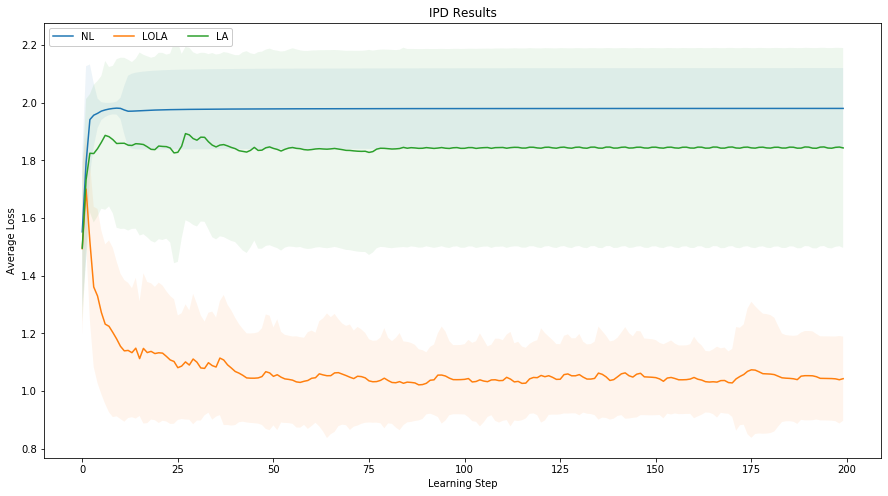

Torch time: 124.8630383014679


In [0]:
#@title IPD torch
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
alpha = 1
std = 1

th = init_th(dims, std)
update_fn={'nl':jit(partial(update_th,Ls,dims,alpha,'nl')),
           'la':jit(partial(update_th,Ls,dims,alpha,'la')),
           'lola':jit(partial(update_th,Ls,dims,alpha,'lola'))}

def convert2torch(th):
    torch_th = [torch.from_numpy(np.array(x)) for x in th]
    for x in torch_th:
        x.requires_grad=True
    return torch_th

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
plt.figure(figsize=(15, 8))
for algo in ['nl', 'lola', 'la', 'sos', 'sga', 'co' , 'eg', 'cgd', 'lss'][0:3]:
#   losses_out = np.zeros((num_runs, num_epochs))
  torch_losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    # th = init_th(dims, std)
    # torch_th = convert2torch(th)
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    for k in range(num_epochs):
      torch_th, torch_losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
      torch_losses_out[i, k] = (1-gamma)*torch_losses[0].data.numpy()
    #   th, losses = update_fn[algo](th)
    #   losses_out[i, k] = (1-gamma)*losses[0]
  torch_mean = np.mean(torch_losses_out, axis=0)
  torch_dev = np.std(torch_losses_out, axis=0)
#   mean = np.mean(losses_out, axis=0)
#   dev = np.std(losses_out, axis=0)
  plt.plot(np.arange(num_epochs), torch_mean)
  plt.fill_between(np.arange(num_epochs), torch_mean-torch_dev, torch_mean+torch_dev, alpha=0.08)
#   plt.plot(np.arange(num_epochs), mean)
#   plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)

plt.title('IPD Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['NL', 'LOLA', 'LA', 'SOS', 'SGA', 'CO',  'EG', 'CGD', 'LSS' ][0:3], loc='upper left', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Torch time:', time.time()-t1)